# Geothermal Feasibility Study



In [1]:
import sys  
sys.path.insert(0, 'Libraries/') 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
xl = pd.ExcelFile('Climate/Burlington, VT 2021-01-01 to 2021-12-31.xlsx')
weather = pd.read_excel("Climate/Burlington, VT 2021-01-01 to 2021-12-31.xlsx",
                        sheet_name=xl.sheet_names[0],header=0,
                        converters= {'datetime': pd.to_datetime},)
weather = weather.set_index('datetime')
weather.head(1) 

,name,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-01,"Burlington, VT",-3.9,-7.7,-8.8,68.6,0.0,NaN,NaN,0.0,6.3,...,1030.1,48.8,16.0,NaN,NaN,NaN,NaN,Partially cloudy,partly-cloudy-night,"72622564776,KPBG,KBTV,KMVL,72611454771,7261701..."


In [4]:
weather.columns

Index(['name', 'temp', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'preciptype', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
       'solarenergy', 'uvindex', 'severerisk', 'conditions', 'icon',
       'stations'],
      dtype='object')

In [5]:
interp_method = 'linear' 
weather['solarradiation'] = weather['solarradiation'].fillna(0.0)
weather['cloudcover'] = weather['cloudcover'].fillna(0.0)
weather['precip'] = weather['precip'].fillna(0.0)
weather['windspeed'] = weather['windspeed'].interpolate(interp_method)
weather['temp'] = weather['temp'].interpolate(interp_method)
weather['solarradiation'] = weather['solarradiation'].interpolate(interp_method)
weather['cloudcover'] = weather['cloudcover'].interpolate(interp_method)
weather['dew'] = weather['dew'].interpolate(interp_method)
weather['precip'] = weather['precip'].interpolate(interp_method)
weather['humidity'] = weather['humidity'].interpolate(interp_method)

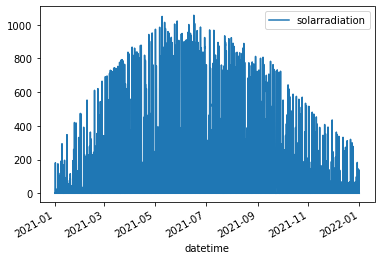

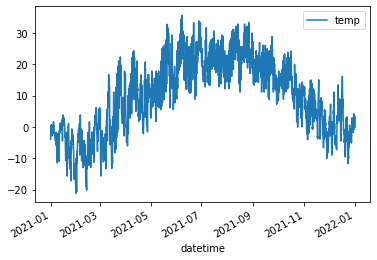

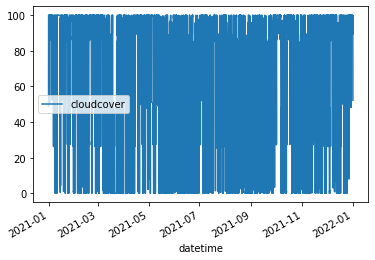

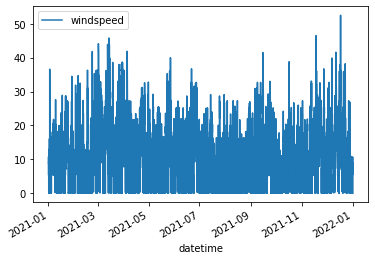

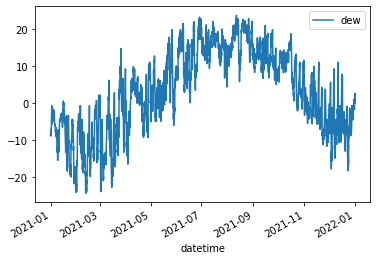

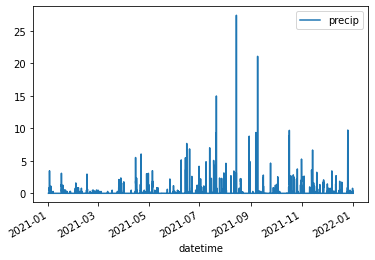

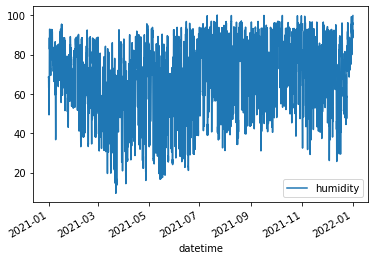

In [6]:
ax0 = weather.plot(y='solarradiation')
ax0 = weather.plot(y='temp')
ax0 = weather.plot(y='cloudcover')
ax0 = weather.plot(y='windspeed')
ax0 = weather.plot(y='dew')
ax0 = weather.plot(y='precip')
ax0 = weather.plot(y='humidity')

In [7]:
from scipy.interpolate import interp1d
interp_method = 'cubic'

t_data = np.arange(0,weather.shape[0]*15*60,15*60)
U_atm = np.abs(weather['windspeed'][:].to_numpy()/3.6) #converted from km/h to m/s
T_atm = weather['temp'][:].to_numpy()
q_sun = weather['solarradiation'][:].to_numpy()
# CC = weather['Cloud Cover'][:].to_numpy()
cc = weather['cloudcover'][:].to_numpy()/100. # converted from % to fraction
rh = weather['humidity'][:].to_numpy() # left as %
p_r = weather['precip'][:].to_numpy()*1e-3/(15*60) #converted to mm to m/s 
T_dp = weather['dew'][:].to_numpy()
f_U_atm = interp1d(t_data,U_atm,kind=interp_method)
def U_atmospheric(t):
    global f_U_atm
    return np.maximum(f_U_atm(t),0.)
f_T_atm = interp1d(t_data,T_atm,kind=interp_method)
def T_atmospheric(t):
    global f_T_atm
    return f_T_atm(t)
f_q_sun = interp1d(t_data,q_sun,kind=interp_method)
def sun_irradiation(t):
    global f_q_sun
    return np.maximum(f_q_sun(t),0.)
f_CC = interp1d(t_data,cc,kind=interp_method)
def cloud_cover(t):
    global f_CC
    return np.clip(f_CC(t),0.,1.)
f_T_dp = interp1d(t_data,T_dp,kind=interp_method)
def dew_point(t):
    global f_T_dp
    return f_T_dp(t)
f_RH = interp1d(t_data,rh,kind=interp_method)
def relative_humidity(t):
    global f_RH
    return np.clip(f_RH(t),0.,100.)
f_rain = interp1d(t_data,p_r,kind=interp_method)
def rain_rate(t):
    global f_rain
    return np.maximum(f_rain(t),0.)


importing libraries to solve heat transfer problem

In [8]:
import scipy.constants as csts
from scipy.integrate import solve_ivp
import thermodynamics as thermo
import HT_external_convection as extconv
import HT_natural_convection as natconv

## Part 1: fixed temperature ceiling model
### find: cooling demand and energy cost

#### Convection heat transfer on upper surface 

Convection heat transfer is determined by the relative strength of forced and natural convection. Here the forced convection is the wind over the roof. Regardless of the direction of the wind, the length of the slab is always assumed to be the dimension of the square making the roof $L$. Thermodynamics properties with a subscript $f$ denotes properties evaluated at the film temperature
$$
T_f = \frac{T_s+T_\infty}{2}\,,
$$ where $T_s$ is the temperature at the surface of the slab. For every time iteration, the following non-dimensional numbers are computed:
* Reynolds number quantifies the wind strength
$$
Re=\frac{U_\infty L}{\nu_f}
$$
* Grashoff number quantifies the natural convection strength
$$
Gr=\frac{g\beta\left\vert T_s-T_\infty\right\vert L^3}{\nu_f^2}
$$
* Richardson number quantifies the relative strength of natural convection vs forced wind convection
$$
Ri=\frac{Gr}{Re^2}
$$
* Rayleigh number is required for Nusselt number convection in case of natural convection.
$$
Ra=\frac{g\beta\left\vert T_s-T_\infty\right\vert L^3}{\nu_f\alpha_f}
$$

The following algorithm determines the local average convection coefficient
$$
\bar{h}=\bar{h}_{forced}+\bar{h}_natural=\frac{\overline{Nu}_{forced}k_f}{L}+\frac{\overline{Nu}_{natural}k_f}{L}
$$
where $\overline{Nu}_{forced}$ is the correlation for the flow over a plate at constant temperature and $\overline{Nu}_{natural}$ is the correlation for natural convection over a horizontal surface at constant temperature. 

* If the wind velocity drops below $U_\infty=0.15\mathrm{m/s}$, there is no forced convection: $h_{forced}=0$
* If $Ri<0.1$, natural convection is negligible, $h_{natural} = 0$, compute $h_{forced}$
* If $Ri>10$, forced convection is negligible, $h_{forced}=0$, compute $h_{natural}$
* If $0.1\leq Ri\leq 10$ compute both $h_{forced}$ and $h_{natural}$

In [30]:
from Libraries import HT_natural_convection as natconv
def outsideconvection(Uinf, T_f,Tinf, air_f,Lplate, Ts):
    Re = np.abs(Uinf)*Lplate/air_f.nu
    Gr = natconv.Gr(beta=air_f.beta,DT=np.abs(Ts-Tinf),D=Lplate,nu=air_f.nu)
    Ra = natconv.Ra(beta=air_f.beta,DT=np.abs(Ts-Tinf),D=Lplate,nu=air_f.nu,alpha=air_f.alpha)
    if (Uinf < 0.15):
        ForcedConvection = False
        NaturalConvection = True
    else:
        Ri = Gr / Re**2
        if Ri < 0.1:
            ForcedConvection = True
            NaturalConvection = False
        elif Ri > 10:
            ForcedConvection = False
            NaturalConvection = True
        else:
            ForcedConvection = True
            NaturalConvection = True
    if ForcedConvection:
        if (Re <= 5e5):
            airflow = extconv.FlatPlate('laminar','isothermal',U_infty=Uinf,nu=air_f.nu,alpha=air_f.alpha, L=Lplate,xi=0,Re_xc= 5e5)
            airflow.average(Lplate)
            hconv_f = airflow.Nu_ave*air_f.k/Lplate
        elif Re > 5e5:
            airflow = extconv.FlatPlate('mixed','isothermal',U_infty=Uinf,nu=air_f.nu,alpha=air_f.alpha, L=Lplate,xi=0,Re_xc= 5e5)
            airflow.average(Lplate)
            hconv_f = airflow.Nu_ave*air_f.k/Lplate
    else:
        hconv_f = 0
    #Natural convection flux
    if NaturalConvection and Ra > 1e4:
        if Ts >= Tinf:
            airflow = natconv.FlatPlate(Ra,air_f.Pr,'upper','hot')
        else:
            airflow = natconv.FlatPlate(Ra,air_f.Pr,'upper','cold')
        hconv_n = airflow.Nu*air_f.k/Lplate
    else:
        hconv_n = 0
    #Total convection flux (here not a function of Ri)
    h = hconv_n + hconv_f
    qpp = h*(Tinf - Ts)
    
    return qpp

#### Radiation between outer surface and sky

#### Definition of $T_{sky}$
* $T_{\infty}$ Air temperature $\mathrm{^\circ C}$
* $T_{dp}$ Dew point temperature $\mathrm{^\circ C}$
* $cc$ Cloud coverage
* $\varepsilon_{clear}$: emissivity of clear blue sky
* $\varepsilon_{sky}=1$

$$
\varepsilon_{clear}=0.711 + 0.56\frac{Tdp}{100} + 0.73\left(\frac{Tdp}{100}\right)^2
$$

$$
Ca = 1. + 0.02224cc + 0.0035cc^2 + 0.00028cc^3
$$

$$
T_{sky}  = (Ca\varepsilon_{clear})^{0.25}(Tinf+273.15)
$$
$$
h_{rad,sky}= \varepsilon_{sky}\sigma((T_{sky}+273.15)+(T_s+273.15))
        ((T_{sky}+273.15)^2+(T_s+273.15)^2)
$$

In [16]:
def T_sky(Tdp,cc,Tinf,Ts):
    eps_clear = 0.711 + 0.56*(Tdp/100.) + 0.73*(Tdp/100.)**2
    Ca = 1. + 0.02224*cc + 0.0035*cc**2 + 0.00028*cc**3
    Tsky  = (Ca*eps_clear)**0.25*thermo.C2K(Tinf)
    hr = eps_sky*csts.sigma*(Tsky+thermo.C2K(Ts))* \
        (Tsky**2+thermo.C2K(Ts)**2)
    return Tsky,hr
def skyradiation(Tdp,cc,Tinf,Ts):
    # Ts must be in Celsius
    Tsky,hr = T_sky(Tdp,cc,Tinf,Ts)
    qsky = eps_sky*csts.sigma*(Tsky**4 - thermo.C2K(Ts)**4)
    return qsky



### Wet Bulb Temperature Correlation

$$
T_{WB}=T_\infty\arctan\left[0.1515977\sqrt{RH + 8.313659}\right] + \arctan(T_\infty + RH) - \arctan(RH - 1.676331) + 0.00391838RH^{1.5}\arctan(0.023101RH) \
            - 4.686035
$$

### Heat Flux of Cooling by Rain
$$
q''=\rho C_p P_r(T_{WB}-Ts(t))
$$

where $\rho=1000\mathrm{kg/m^3}$, $C_p=4.19\times10^3\mathrm{J/Kg.K}$ and $P_r$ is the precipitation.

In [17]:
def T_wet_bulb(T,RH):
    return T * np.arctan(0.1515977*(RH + 8.313659)**0.5) + np.arctan(T + RH) \
            - np.arctan(RH - 1.676331) + 0.00391838*RH**1.5*np.arctan(0.023101*RH) \
            - 4.686035
def rain(pr,Tinf,RH,Ts):
    Twb = T_wet_bulb(Tinf,RH)
#     print("rain",pr,Twb,Tinf,RH,Ts)
    rho = 1000.
    Cp = 4.19e3
    return rho*Cp*pr*(Twb - Ts)

### Function to be solved

Conservation of energy equation is applied to the outer surface of the slab, which is assumed to be at uniform temperature $T_s(t)$:

$$
\iint_A\rho_{ins}C_{p,ins}\frac{dT_s}{dt}\rho_{ins}C_{p,ins}A\frac{dT_s}{dt}=q_{sun}+q_{rain}+q_{conv}+q_{rad,sky}-q_{cond}=(q''_{sun}+q''_{rain}+q''_{conv}+q''_{rad,sky}-q''_{cond})A
$$

Therefore the equation govering the surface temperature is:
$$
\frac{dT_s}{dt}=\frac{1}{\rho_{ins}C_{p,ins}}(q''_{sun}+q''_{rain}+q''_{conv}+q''_{rad,sky}-q''_{cond})
$$

The cooling demand fluctuates over time:

$$
q''_{cool}(t)=\begin{cases}
\frac{1}{R''_{tot}}(T_s(t)-T_{s,lower}) &\text{if }T_s(t)\geq T_{s,lower}\\
0 & \text{otherwise}
\end{cases}
$$
where $R''_{tot}=R''_{cond,ins}+R''_{cond,concrete}$.

Note that the irradiation from the sun is only partly absorbed by the surface:
$$
q''_{sun}=\alpha_{abs}I_{sun}(t)\;,
$$
where $\alpha_{abs}$ is the surface absorptivity ($0\leq \alpha_{abs}\leq 1$, always) and $I_{sun}(t)$ is the measure irradiation from the sun.

In [18]:
def f(t,T):
    global Lplate,Rpp_tot,eps,f_U_atm,f_T_atm,f_q_sun,rho,C_p,alpha_s,f_CC,f_T_dp
    # film temperature between ambient and upper surface
    Tinf = T_atmospheric(t)
    Uinf = U_atmospheric(t)
    
    T_f = (T[0]+Tinf)/2
    air_f = thermo.Fluid('air',T_f,"C")
    Tdp = dew_point(t)
    cc = cloud_cover(t)
    pr = rain_rate(t)
    rh = relative_humidity(t)
    
    
    qpp_sun = alpha_s*sun_irradiation(t)
    
    qpp_sky = skyradiation(Tdp,cc,Tinf,T[0]) #h_rad(T_s - T_sky)
    
    qpp_conv = outsideconvection(Uinf, T_f,Tinf, air_f,Lplate, T[0]) #h_conv_tot(T_s -T_inf)
    
    qpp_rain = rain(pr,Tinf,rh,T[0]) #h_rain(Twb - T_s)
    
    qpp_cond = 1/Rpp_tot*(T[0] - T_s_lower) 
    
    qpp_total = qpp_sun + qpp_sky + qpp_conv + qpp_rain - qpp_cond
    
    return qpp_total/(rho*C_p)

In [19]:
from Libraries import HT_thermal_resistance as res
rho = 20.
C_p = 2500.
k_ins = 0.022
H_ins = 0.05
k_concrete = 0.17
H_concrete = 0.1
Rpp = []
Rpp.append(res.Resistance("$R''_{cond,ins}$","W/m^2"))
Rpp.append(res.Resistance("$R''_{cond,conc}$","W/m^2"))
Rpp[0].cond_plane(k_ins,H_ins)
Rpp[1].cond_plane(k_concrete,H_concrete)
Rpp_tot = Rpp[0].R + Rpp[1].R
alpha_s = 0.5
eps_sky = 1.
Lplate = 10.
A = Lplate**2
T_s_lower = 20.

tmax = t_data[-1]
mask = np.where(t_data <= tmax)
sol = solve_ivp(f,[0,tmax],[f_T_atm(t_data[0])],method='LSODA',t_eval=t_data[mask],max_step=10*60.)

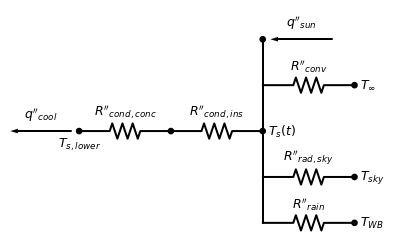

In [21]:
import schemdraw as schem
import schemdraw.elements as elm
with schem.Drawing() as d:
    d += elm.Dot().label("$T_{s,lower}$",'bottom')
    d += elm.Resistor().label(Rpp[1].name)
    d += elm.Dot()
    d += (R0 := elm.Resistor().label(Rpp[0].name))
    d += elm.Dot().label("$T_s(t)$",'right')
    d += (L0 := elm.Line().down().at(R0.end).length(1.5))
    d += elm.Resistor().right().label("$R''_{rad,sky}$")
    d += elm.Dot().label("$T_{sky}$",'right')
    d += elm.Line().down().at(L0.end).length(1.5)
    d += elm.Resistor().right().label("$R''_{rain}$")
    d += elm.Dot().label("$T_{WB}$",'right')
    d += (L1 := elm.Line().up().at(R0.end).length(1.5))
    d += elm.Resistor().right().label("$R''_{conv}$")
    d += elm.Dot().label("$T_{\infty}$",'right')
    d += elm.Line().up().at(L1.end).length(1.5)
    d += elm.Dot()
    d += elm.Line(arrow='<-').right().at((6.25,3)).length(2).label("$q''_{sun}$")
    d += elm.Line(arrow='<-').right().at((-2.25,0)).length(2).label("$q''_{cool}$")
    
    

### Main code

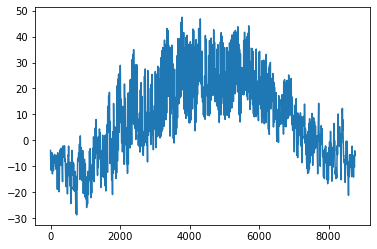

In [20]:
plt.plot(sol.y[0])

### Output

Creation of two new columns, one for upper surface temperature, the other as the cooling energy needed to maintain target temperature on the lower surface.

In [22]:
weather['q_cool_iso_T_ceiling'] = np.maximum(1/Rpp_tot*(sol.y[0] - T_s_lower)*A,0.)

In [23]:
weather['q_cool_iso_T_ceiling'].max()

959.9604792613902

In [24]:
weather['q_cool_iso_T_ceiling'].argmax()

3783

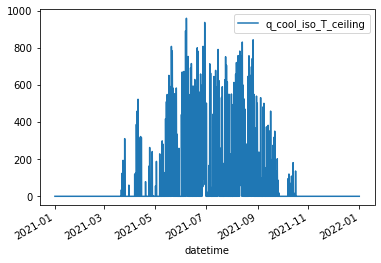

In [26]:
ax0 = weather.plot(y='q_cool_iso_T_ceiling')

### Total energy to be extracted 

In [29]:
weather['q_cool_iso_T_ceiling'].sum()*15*60/3600


130590.3617235863

## Part 2: realistic room model
### find: cooling demand with height 5m in comparison to part 1 and energy cost

### Convection heat transfer on lower surface (NEEDS MODIFICATIONS)

I only change the first 2 lines Everything about forced convection must go

# NOTE
There shouldn't be any Ri, Re or $U_\infty$ in the derivation above and the simulation below

In [54]:
def insideconvection(Uinf,T_f,Tinf, air_f,Lplate, Ts):
    Re = Uinf*Lplate/air_f.nu
    Gr = natconv.Gr(beta=air_f.beta,DT=np.abs(Ts-Tinf),D=Lplate,nu=air_f.nu)
    Ra = natconv.Ra(beta=air_f.beta,DT=np.abs(Ts-Tinf),D=Lplate,nu=air_f.nu,alpha=air_f.alpha)
    if (Uinf < 0.15):
        ForcedConvection = False
        NaturalConvection = True
    else:
        Ri = Gr / Re**2
        if Ri < 0.1:
            ForcedConvection = True
            NaturalConvection = False
        elif Ri > 10:
            ForcedConvection = False
            NaturalConvection = True
        else:
            ForcedConvection = True
            NaturalConvection = True
    if ForcedConvection:
        if (Re <= 5e5):
            airflow = extconv.FlatPlate('laminar','isothermal',U_infty=Uinf,nu=air_f.nu,alpha=air_f.alpha, L=Lplate,xi=0,Re_xc= 5e5)
            airflow.average(Lplate)
            hconv_f = airflow.Nu_ave*air_f.k/Lplate
        elif Re > 5e5:
            airflow = extconv.FlatPlate('mixed','isothermal',U_infty=Uinf,nu=air_f.nu,alpha=air_f.alpha, L=Lplate,xi=0,Re_xc= 5e5)
            airflow.average(Lplate)
            hconv_f = airflow.Nu_ave*air_f.k/Lplate
    else:
        hconv_f = 0
    #Natural convection flux
    ''' The following lines need modifications'''
    if NaturalConvection and Ra > 1e4:
        if Ts >= Tinf:
            airflow = natconv.FlatPlate(Ra,air_f.Pr,'upper','hot')
        else:
            airflow = natconv.FlatPlate(Ra,air_f.Pr,'upper','cold')
        hconv_n = airflow.Nu*air_f.k/Lplate
    else:
        hconv_n = 0
    #Total convection flux (here not a function of Ri)
    h = hconv_n + hconv_f
    qpp = h*(Tinf - Ts) #especially that one
    
    
    return qpp

### Governing equation of the system

Conservation of energy equation is applied to the outer surface of the slab, which is assumed to be at uniform temperature $T_s(t)$:

$$
\iint_A\rho_{ins}C_{p,ins}\frac{dT_s}{dt}\rho_{ins}C_{p,ins}A\frac{dT_s}{dt}=q_{sun}+q_{rain}+q_{conv}+q_{rad,sky}-q_{cond}=(q''_{sun}+q''_{rain}+q''_{conv}+q''_{rad,sky}-q''_{cond})A
$$

Therefore the equation govering the surface temperature is:
$$
\frac{dT_s}{dt}=\frac{1}{\rho_{ins}C_{p,ins}}(q''_{sun}+q''_{rain}+q''_{conv}+q''_{rad,sky}-q''_{cond})\;\;\;\;\;\mathrm{Eq.\;(1)}
$$

The cooling demand fluctuates over time:

$$
q''_{cool}(t)=\begin{cases}
\frac{1}{R''_{tot}}(T_s(t)-T_{s,lower}) &\text{if }T_s(t)\geq T_{s,lower}\\
0 & \text{otherwise}
\end{cases}
$$
where $R''_{tot}=R''_{cond,ins}+R''_{cond,concrete}$.

Note that the irradiation from the sun is only partly absorbed by the surface:
$$
q''_{sun}=\alpha_{abs}I_{sun}(t)\;,
$$
where $\alpha_{abs}$ is the surface absorptivity ($0\leq \alpha_{abs}\leq 1$, always) and $I_{sun}(t)$ is the measure irradiation from the sun.

In [49]:
def f_room(t,T):
    global Lplate,Rpp_tot,eps,f_U_atm,f_T_atm,f_q_sun,rho,C_p,alpha_s,f_CC,f_T_dp,T_sp,DT_sp
    global q_hvac,T_hvac,V_room,heating_coef,q_people
    dTdt = np.zeros(len(T))
    # film temperature between ambient and upper surface
    Tinf = T_atmospheric(t)
    Uinf = U_atmospheric(t)
    
    T_f = (T[0]+Tinf)/2
    air_f = thermo.Fluid('air',T_f,"C")
    Tdp = dew_point(t)
    cc = cloud_cover(t)
    pr = rain_rate(t)
    rh = relative_humidity(t)
    
    
    qpp_sun = alpha_s*sun_irradiation(t)
    
    qpp_sky = skyradiation(Tdp,cc,Tinf,T[0]) #h_rad(T_s - T_sky)
    
    qpp_conv = outsideconvection(Uinf, T_f,Tinf, air_f,Lplate, T[0]) #h_conv_tot(T_s -T_inf)
    
    qpp_rain = rain(pr,Tinf,rh,T[0]) #h_rain(Twb - T_s)
    
    qpp_cond = 1/Rpp_tot*(T[0] - T[1])
    
    T_f_in = (T[1] + T[2])/2.
    air_f_in = thermo.Fluid('air',T_f_in,"C")
    qpp_conv_in = insideconvection(0.,T_f_in, T[2], air_f_in, Lplate, T[1])
    qpp_total = qpp_sun + qpp_sky + qpp_conv + qpp_rain - qpp_cond
    dTdt[0] = qpp_total/(rho*C_p)
    dTdt[1] = (qpp_cond - qpp_conv_in)/(air_f_in.rho*air_f_in.Cp)
    air_room = thermo.Fluid('air',T[2],"C")

    dTdt[2] = (qpp_conv_in*A + T[3]*q_hvac)/(air_room.rho*air_room.Cp*V_room)
    if T[2] > T_sp + DT_sp:
        if T[3] >= -1:
            dTdt[3] = -1./T_hvac
    elif T[2] < T_sp - DT_sp:
        if T[3] <= 1.:
            dTdt[3] = 1./T_hvac
#     print(qpp_conv_in,T[1],T[2])
    return dTdt
    


### Main code

The integration in time of Eq. (1) (see above) is realized with the adaptive time-stepping method LSODA available in the library `scipy.integrate` for initial value problem (IVP). The time step is set at 15 mins. The LSODA method automatically subdivides this time step into smaller sub-time steps if the solution experiences large fluctuations. This method guarantees the stability of the simulation if the maximum time steps (15 mins) is small enough. A convergence analysis performed by the instructor determined 15 mins was a good compromise of stability and computational speed.

In [50]:
rho = 20.
C_p = 2500.
k = 0.05
H = 0.05
alpha_s = 0.5
eps_sky = 1.
Lplate = 10.
A = Lplate**2
V_room = A*5.
T_sp = 20.
T_hvac = 4*60
DT_sp = 1.

dt = 4*60
q_hvac = 50000.
tmax = t_data[-1]
mask = np.where(t_data <= tmax)
sol = solve_ivp(f_room,[0,tmax],[f_T_atm(t_data[0]),T_sp,T_sp,0],method='LSODA',t_eval=t_data[mask],max_step=dt)

In [ ]:
plt.figure(dpi=100)
plt.title("Surface temperature")
plt.plot(sol.y[0])
plt.xlabel("increments of 15 mins")
plt.show()

### Output

The solution is stored in the weather dataframe using two new columns, one for upper surface temperature, the other as the cooling energy needed to maintain target temperature on the lower surface.


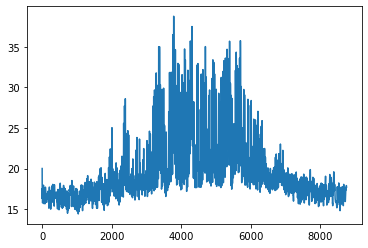

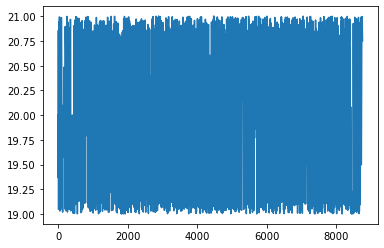

In [55]:
#ceiling temperature
plt.plot(sol.y[1])
plt.show()
#room temperature
plt.plot(sol.y[2])
plt.show()


In [ ]:
weather['q_cooling_var_T_ceiling'] = np.clip(sol.y[3],-1.1,1,0.) 
#this is not energy, should be Watts, as it is, it has no units

In [ ]:
print("Maximum cooling demand: %.0f W" %weather['q_cooling_var_T_ceiling'].max())
print("on %s " %weather.index[weather['q_cooling_var_T_ceiling'].argmax()].strftime("%m/%d/%Y, %H:%M:%S"))

In [ ]:
ax0 = weather['q_cool'].plot()
weather['q_cooling_var_T_ceiling'].plot(ax=ax0)

In [ ]:
weather['q cool'].sum()*15*60/3600

In [ ]:
weather['q cooling_var_T_ceiling'].sum()*15*60/3600

In [ ]:
np.std(sol.y[2])

$$
\int_\text{04/01}^\text{10/31}q_{cool}(t)dt
$$


### Heat transfer analysis 

A similar analysis as the building is performed for the heat exchanger, which is a geothermal cooling system consisting of a pipe in a vertical collector configuration.

#### Assumptions
* Ground is assumed to be at 10C at 2m deep
* Soil is clay
* The outside surface is at soil temperature in the heat exchanger
* Pipes are HDPE
* heat exchanger is assumed to require cool temperature of 12C and return temperature of 22C
* Efficacy is estimated at 0.75
* Indoor temperature is 20C

